In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data

Data were loaded and cleaned. The cleaning process included getting rid of the punctuation marks and converting the texts into lower case.

In [2]:
import string

titles = pd.read_csv("./data/medium_post_titles.csv")
titles.drop(columns=["subtitle", "subtitle_truncated_flag"], inplace=True)

titles.title = titles.title.str.replace('[{}]'.format(string.punctuation), '').str.lower()
titles.title = titles.title.str.replace('‘', '')
titles.title = titles.title.str.replace('’', '')
titles.title = titles.title.str.replace('“', '')
titles.title = titles.title.str.replace('”', '')
titles.title = titles.title.str.replace('—', '')

titles.head()

,category,title
0,work,21 conversations a fun and easy game for team...
1,spirituality,biblical porn at mars hill
2,lgbtqia,cisgender is that a disease
3,equality,call me nat love black cowboys and the frontie...
4,artificial-intelligence,can i train my model on your computer


20% of the data were held out for testing.

In [3]:
from sklearn.model_selection import train_test_split

titles_train, titles_test = train_test_split(titles, train_size=0.8, stratify=titles.category.values)

X_train = titles_train.title.values
X_test = titles_test.title.values

y_train = titles_train.category.values
y_test = titles_test.category.values

In [13]:
import warnings
warnings.filterwarnings('ignore')

The theme labels were converted to one hot representations.

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

integer_encoder = LabelEncoder()
integer_train = integer_encoder.fit_transform(y_train).reshape((-1, 1))
integer_test = integer_encoder.transform(y_test).reshape((-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
onehot_train = onehot_encoder.fit_transform(integer_train)
onehot_test = onehot_encoder.transform(integer_test)

/Users/zhaojieyao/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Tokenization and vectorization

Use TF-IDF to perform bag-of-words vetorization.

We adopted the Penn Treebank Tokenizer. We did not want to include n-grams because it will significantly increase the size of the vocabulary. Terms that appear less than twice or occur in more than 10% of the docuemnts are rejected. This choice is made based on experience extracting features for a naive Bayes model.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

tokenizer = TreebankWordTokenizer()
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, ngram_range=(1, 1), stop_words='english', min_df=2, max_df=0.1)

XMatrix_train = vectorizer.fit_transform(X_train)
vocabulary = np.array(vectorizer.get_feature_names())

XMatrix_test = vectorizer.transform(X_test)

In [6]:
vocabularySize = vocabulary.size
print("Number of terms in the vocabulary: {}".format(vocabularySize))

Number of terms in the vocabulary: 22424


# Multilayer perceptron network

Using the ADAM optimizer to train a multilayer perception network with early stopping according to accuracy of the model tested on the held-out set, we experimented with different network architectures while tuning the dropout rate at different layers.

## 2 hidden layers, 256, 256

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from time import time
from keras.models import load_model

layer1 = Dense(256, activation="relu", input_dim=vocabularySize)
layer2 = Dense(256, activation="relu")
outputLayer = Dense(93, activation="softmax")
classifier0 = Sequential([layer1, layer2, outputLayer])
classifier0.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=25, min_delta=0.01, verbose=1)
best_model_saving = ModelCheckpoint("MLP_best_model_0.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history0 = classifier0.fit(XMatrix_train,onehot_train, epochs=1000, batch_size=2048, validation_data=(XMatrix_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier0 = load_model("MLP_best_model_0.h5")
_, train_accuracy = classifier0.evaluate(XMatrix_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier0.evaluate(XMatrix_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

Using TensorFlow backend.
/Users/zhaojieyao/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhaojieyao/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhaojieyao/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 101134 samples, validate on 25284 samples
Epoch 1/1000
 - 38s - loss: 4.2283 - acc: 0.0626 - val_loss: 3.9302 - val_acc: 0.1606

Epoch 00001: val_acc improved from -inf to 0.16058, saving model to MLP_best_model_0.h5
Epoch 2/1000
 - 41s - loss: 3.4419 - acc: 0.2558 - val_loss: 2.9954 - val_acc: 0.3303

Epoch 00002: val_acc improved from 0.16058 to 0.33033, saving model to MLP_best_model_0.h5
Epoch 3/1000
 - 38s - loss: 2.4466 - acc: 0.4357 - val_loss: 2.5298 - val_acc: 0.3942

Epoch 00003: val_acc improved from 0.33033 to 0.39424, saving model to MLP_best_model_0.h5
Epoch 4/1000
 - 40s - loss: 1.9084 - acc: 0.5348 - val_loss: 2.4605 - val_acc: 0.4117

Epoch 00004: val_acc improved from 0.39424 to 0.41168, saving model to MLP_best_model_0.h5
Epoch 5/1000
 - 39s - loss: 1.5950 - acc: 0.6013 - val_loss: 2.4897 - val_acc: 0.4103

Epoch 00005: val_acc did not impr

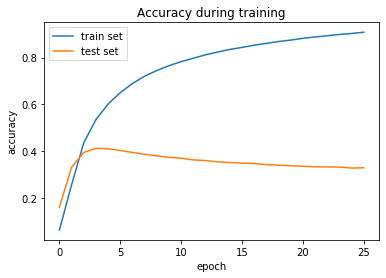

In [8]:
def plotFittingAccuracy(history):
    
    plt.plot(history.history['acc'], label='train set')
    plt.plot(history.history['val_acc'], label='test set')
    
    plt.title("Accuracy during training")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    
plotFittingAccuracy(history0)

## 2 hidden layers, 512, 256

Train on 101134 samples, validate on 25284 samples
Epoch 1/1000
 - 90s - loss: 4.1596 - acc: 0.1090 - val_loss: 3.7544 - val_acc: 0.1786

Epoch 00001: val_acc improved from -inf to 0.17857, saving model to MLP_best_model_1.h5
Epoch 2/1000
 - 89s - loss: 3.1097 - acc: 0.3196 - val_loss: 2.7137 - val_acc: 0.3696

Epoch 00002: val_acc improved from 0.17857 to 0.36964, saving model to MLP_best_model_1.h5
Epoch 3/1000
 - 89s - loss: 2.1510 - acc: 0.4857 - val_loss: 2.4493 - val_acc: 0.4125

Epoch 00003: val_acc improved from 0.36964 to 0.41247, saving model to MLP_best_model_1.h5
Epoch 4/1000
 - 89s - loss: 1.6776 - acc: 0.5808 - val_loss: 2.4575 - val_acc: 0.4142

Epoch 00004: val_acc improved from 0.41247 to 0.41421, saving model to MLP_best_model_1.h5
Epoch 5/1000
 - 88s - loss: 1.3861 - acc: 0.6480 - val_loss: 2.5450 - val_acc: 0.4046

Epoch 00005: val_acc did not improve from 0.41421
Epoch 6/1000
 - 88s - loss: 1.1803 - acc: 0.6956 - val_loss: 2.6686 - val_acc: 0.3948

Epoch 00006: val

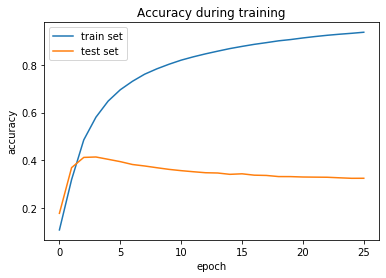

In [9]:
layer1 = Dense(512, activation="relu", input_dim=vocabularySize)
layer2 = Dense(256, activation="relu")
outputLayer = Dense(93, activation="softmax")
classifier1 = Sequential([layer1, layer2, outputLayer])
classifier1.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=25, min_delta=0.01, verbose=1)
best_model_saving = ModelCheckpoint("MLP_best_model_1.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history1 = classifier1.fit(XMatrix_train,onehot_train, epochs=1000, batch_size=2048, validation_data=(XMatrix_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier1 = load_model("MLP_best_model_1.h5")
_, train_accuracy = classifier1.evaluate(XMatrix_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier1.evaluate(XMatrix_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history1)

## 2 hidden layers, 512, 512

Train on 101134 samples, validate on 25284 samples
Epoch 1/1000
 - 57s - loss: 4.1165 - acc: 0.0895 - val_loss: 3.6524 - val_acc: 0.2014

Epoch 00001: val_acc improved from -inf to 0.20143, saving model to MLP_best_model_2.h5
Epoch 2/1000
 - 57s - loss: 2.9422 - acc: 0.3399 - val_loss: 2.6097 - val_acc: 0.3796

Epoch 00002: val_acc improved from 0.20143 to 0.37961, saving model to MLP_best_model_2.h5
Epoch 3/1000
 - 58s - loss: 2.0339 - acc: 0.5031 - val_loss: 2.4389 - val_acc: 0.4124

Epoch 00003: val_acc improved from 0.37961 to 0.41236, saving model to MLP_best_model_2.h5
Epoch 4/1000
 - 58s - loss: 1.5789 - acc: 0.6013 - val_loss: 2.4931 - val_acc: 0.4080

Epoch 00004: val_acc did not improve from 0.41236
Epoch 5/1000
 - 57s - loss: 1.2930 - acc: 0.6656 - val_loss: 2.6174 - val_acc: 0.3969

Epoch 00005: val_acc did not improve from 0.41236
Epoch 6/1000
 - 57s - loss: 1.0899 - acc: 0.7146 - val_loss: 2.7648 - val_acc: 0.3874

Epoch 00006: val_acc did not improve from 0.41236
Epoch 7

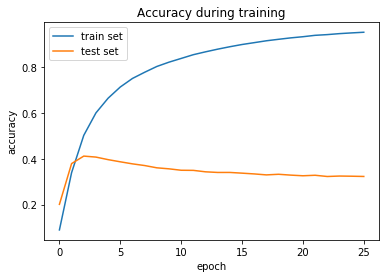

In [10]:
layer1 = Dense(512, activation="relu", input_dim=vocabularySize)
layer2 = Dense(512, activation="relu")
outputLayer = Dense(93, activation="softmax")
classifier2 = Sequential([layer1, layer2, outputLayer])
classifier2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=25, min_delta=0.01, verbose=1)
best_model_saving = ModelCheckpoint("MLP_best_model_2.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history2 = classifier2.fit(XMatrix_train,onehot_train, epochs=1000, batch_size=2048, validation_data=(XMatrix_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier2 = load_model("MLP_best_model_2.h5")
_, train_accuracy = classifier2.evaluate(XMatrix_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier2.evaluate(XMatrix_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history2)

We first tested networks with two hidden layers, while the size of the layers varied, 256-256 units, 512-256 units and 512-512 units. Different configurations all had similar performance, about 41% accuracy on the test set. Thus, a setup of 256-256 units should be the most efficient choice.

## 3 hidden layers, 256, 256, 256 

Train on 101134 samples, validate on 25284 samples
Epoch 1/1000
 - 68s - loss: 4.2142 - acc: 0.0562 - val_loss: 3.9519 - val_acc: 0.1085

Epoch 00001: val_acc improved from -inf to 0.10853, saving model to MLP_best_model_3.h5
Epoch 2/1000
 - 65s - loss: 3.3886 - acc: 0.2384 - val_loss: 2.8947 - val_acc: 0.3296

Epoch 00002: val_acc improved from 0.10853 to 0.32962, saving model to MLP_best_model_3.h5
Epoch 3/1000
 - 65s - loss: 2.3515 - acc: 0.4345 - val_loss: 2.6079 - val_acc: 0.3863

Epoch 00003: val_acc improved from 0.32962 to 0.38629, saving model to MLP_best_model_3.h5
Epoch 4/1000
 - 64s - loss: 1.8407 - acc: 0.5443 - val_loss: 2.6363 - val_acc: 0.3946

Epoch 00004: val_acc improved from 0.38629 to 0.39460, saving model to MLP_best_model_3.h5
Epoch 5/1000
 - 65s - loss: 1.5412 - acc: 0.6114 - val_loss: 2.7428 - val_acc: 0.3895

Epoch 00005: val_acc did not improve from 0.39460
Epoch 6/1000
 - 67s - loss: 1.3262 - acc: 0.6605 - val_loss: 2.8979 - val_acc: 0.3758

Epoch 00006: val

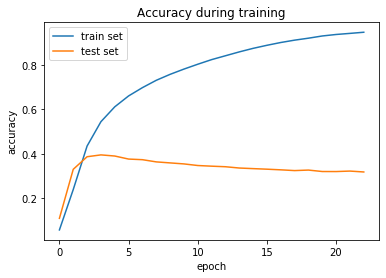

In [15]:
layer1 = Dense(256, activation="relu", input_dim=vocabularySize)
layer2 = Dense(256, activation="relu")
layer3 = Dense(256, activation="relu")
outputLayer = Dense(93, activation="softmax")
classifier3 = Sequential([layer1, layer2, layer3, outputLayer])
classifier3.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=20, min_delta=0.01, verbose=1)
best_model_saving = ModelCheckpoint("MLP_best_model_3.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history3 = classifier3.fit(XMatrix_train,onehot_train, epochs=1000, batch_size=2048, validation_data=(XMatrix_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier3 = load_model("MLP_best_model_3.h5")
_, train_accuracy = classifier3.evaluate(XMatrix_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier3.evaluate(XMatrix_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history3)

We then decided to increase the number of hidden layers in hope accuracy might increase. However, the performance did not surpass 41% accuracy, which indicates more elaborate network structures might not increase the performance.

## 2 hidden layers, 256 (dropout 0.1), 256

Train on 101134 samples, validate on 25284 samples
Epoch 1/1000
 - 40s - loss: 4.2373 - acc: 0.0685 - val_loss: 3.9387 - val_acc: 0.1432

Epoch 00001: val_acc improved from -inf to 0.14321, saving model to MLP_best_model_4.h5
Epoch 2/1000
 - 39s - loss: 3.4489 - acc: 0.2498 - val_loss: 2.9925 - val_acc: 0.3187

Epoch 00002: val_acc improved from 0.14321 to 0.31874, saving model to MLP_best_model_4.h5
Epoch 3/1000
 - 39s - loss: 2.4790 - acc: 0.4241 - val_loss: 2.5398 - val_acc: 0.3910

Epoch 00003: val_acc improved from 0.31874 to 0.39100, saving model to MLP_best_model_4.h5
Epoch 4/1000
 - 39s - loss: 1.9582 - acc: 0.5224 - val_loss: 2.4531 - val_acc: 0.4079

Epoch 00004: val_acc improved from 0.39100 to 0.40793, saving model to MLP_best_model_4.h5
Epoch 5/1000
 - 39s - loss: 1.6570 - acc: 0.5858 - val_loss: 2.4709 - val_acc: 0.4112

Epoch 00005: val_acc improved from 0.40793 to 0.41121, saving model to MLP_best_model_4.h5
Epoch 6/1000
 - 39s - loss: 1.4396 - acc: 0.6346 - val_loss: 2

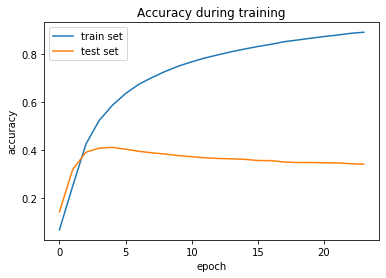

In [17]:
layer1 = Dense(256, activation="relu", input_dim=vocabularySize)
layer2 = Dense(256, activation="relu")
outputLayer = Dense(93, activation="softmax")
classifier4 = Sequential([layer1, Dropout(0.1), layer2, outputLayer])
classifier4.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=20, min_delta=0.01, verbose=1)
best_model_saving = ModelCheckpoint("MLP_best_model_4.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history4 = classifier4.fit(XMatrix_train,onehot_train, epochs=1000, batch_size=2048, validation_data=(XMatrix_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier4 = load_model("MLP_best_model_4.h5")
_, train_accuracy = classifier4.evaluate(XMatrix_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier4.evaluate(XMatrix_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history4)

## 2 hidden layers, 256 (dropout 0.2), 256

Train on 101134 samples, validate on 25284 samples
Epoch 1/1000
 - 40s - loss: 4.2380 - acc: 0.0540 - val_loss: 3.9683 - val_acc: 0.1274

Epoch 00001: val_acc improved from -inf to 0.12735, saving model to MLP_best_model_5.h5
Epoch 2/1000
 - 39s - loss: 3.5442 - acc: 0.2300 - val_loss: 3.0906 - val_acc: 0.3119

Epoch 00002: val_acc improved from 0.12735 to 0.31194, saving model to MLP_best_model_5.h5
Epoch 3/1000
 - 39s - loss: 2.5878 - acc: 0.4062 - val_loss: 2.5848 - val_acc: 0.3889

Epoch 00003: val_acc improved from 0.31194 to 0.38886, saving model to MLP_best_model_5.h5
Epoch 4/1000
 - 39s - loss: 2.0522 - acc: 0.5031 - val_loss: 2.4676 - val_acc: 0.4061

Epoch 00004: val_acc improved from 0.38886 to 0.40611, saving model to MLP_best_model_5.h5
Epoch 5/1000
 - 39s - loss: 1.7389 - acc: 0.5699 - val_loss: 2.4663 - val_acc: 0.4100

Epoch 00005: val_acc improved from 0.40611 to 0.41002, saving model to MLP_best_model_5.h5
Epoch 6/1000
 - 40s - loss: 1.5167 - acc: 0.6188 - val_loss: 2

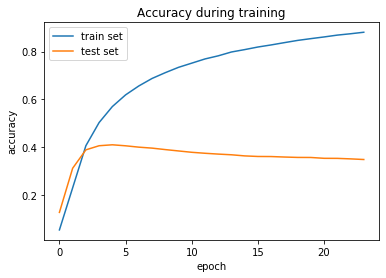

In [18]:
layer1 = Dense(256, activation="relu", input_dim=vocabularySize)
layer2 = Dense(256, activation="relu")
outputLayer = Dense(93, activation="softmax")
classifier5 = Sequential([layer1, Dropout(0.2), layer2, outputLayer])
classifier5.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=20, min_delta=0.01, verbose=1)
best_model_saving = ModelCheckpoint("MLP_best_model_5.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history5 = classifier5.fit(XMatrix_train,onehot_train, epochs=1000, batch_size=2048, validation_data=(XMatrix_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier5 = load_model("MLP_best_model_5.h5")
_, train_accuracy = classifier5.evaluate(XMatrix_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier5.evaluate(XMatrix_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history5)

## 2 hidden layers, 256 (dropout 0.4), 256

Train on 101134 samples, validate on 25284 samples
Epoch 1/1000
 - 40s - loss: 4.2497 - acc: 0.0653 - val_loss: 3.9886 - val_acc: 0.1298

Epoch 00001: val_acc improved from -inf to 0.12984, saving model to MLP_best_model_6.h5
Epoch 2/1000
 - 39s - loss: 3.5934 - acc: 0.2163 - val_loss: 3.1284 - val_acc: 0.3018

Epoch 00002: val_acc improved from 0.12984 to 0.30177, saving model to MLP_best_model_6.h5
Epoch 3/1000
 - 39s - loss: 2.6806 - acc: 0.3841 - val_loss: 2.6039 - val_acc: 0.3794

Epoch 00003: val_acc improved from 0.30177 to 0.37945, saving model to MLP_best_model_6.h5
Epoch 4/1000
 - 38s - loss: 2.1790 - acc: 0.4735 - val_loss: 2.4644 - val_acc: 0.4087

Epoch 00004: val_acc improved from 0.37945 to 0.40868, saving model to MLP_best_model_6.h5
Epoch 5/1000
 - 39s - loss: 1.8861 - acc: 0.5352 - val_loss: 2.4385 - val_acc: 0.4144

Epoch 00005: val_acc improved from 0.40868 to 0.41441, saving model to MLP_best_model_6.h5
Epoch 6/1000
 - 38s - loss: 1.6764 - acc: 0.5812 - val_loss: 2

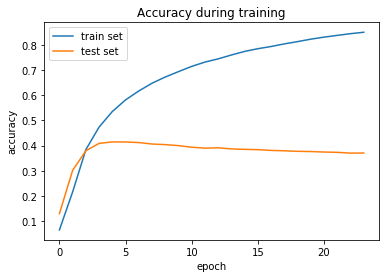

In [19]:
layer1 = Dense(256, activation="relu", input_dim=vocabularySize)
layer2 = Dense(256, activation="relu")
outputLayer = Dense(93, activation="softmax")
classifier6 = Sequential([layer1, Dropout(0.4), layer2, outputLayer])
classifier6.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=20, min_delta=0.01, verbose=1)
best_model_saving = ModelCheckpoint("MLP_best_model_6.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history6 = classifier6.fit(XMatrix_train,onehot_train, epochs=1000, batch_size=2048, validation_data=(XMatrix_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier6 = load_model("MLP_best_model_6.h5")
_, train_accuracy = classifier6.evaluate(XMatrix_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier6.evaluate(XMatrix_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history6)

Dropout was introduced to the first hidden layer to prevent overfitting. We tested three different rates 0.1, 0.2, 0.4 in the 2-hidden layer (256-256 unit) network. The resulted test set accuracy showed that for our task,  dropout did not affect the performance of the network.

# Evaluation

The above analysis showed the network with 2 hidden layers of 256 units (with or without dropout) was able to achieve equal performance as more sophisticated architectures. The multilayer perceptron network generated slighly better (about 5% increase) accuracy.

Average multiclass precision: 0.44868887381401784


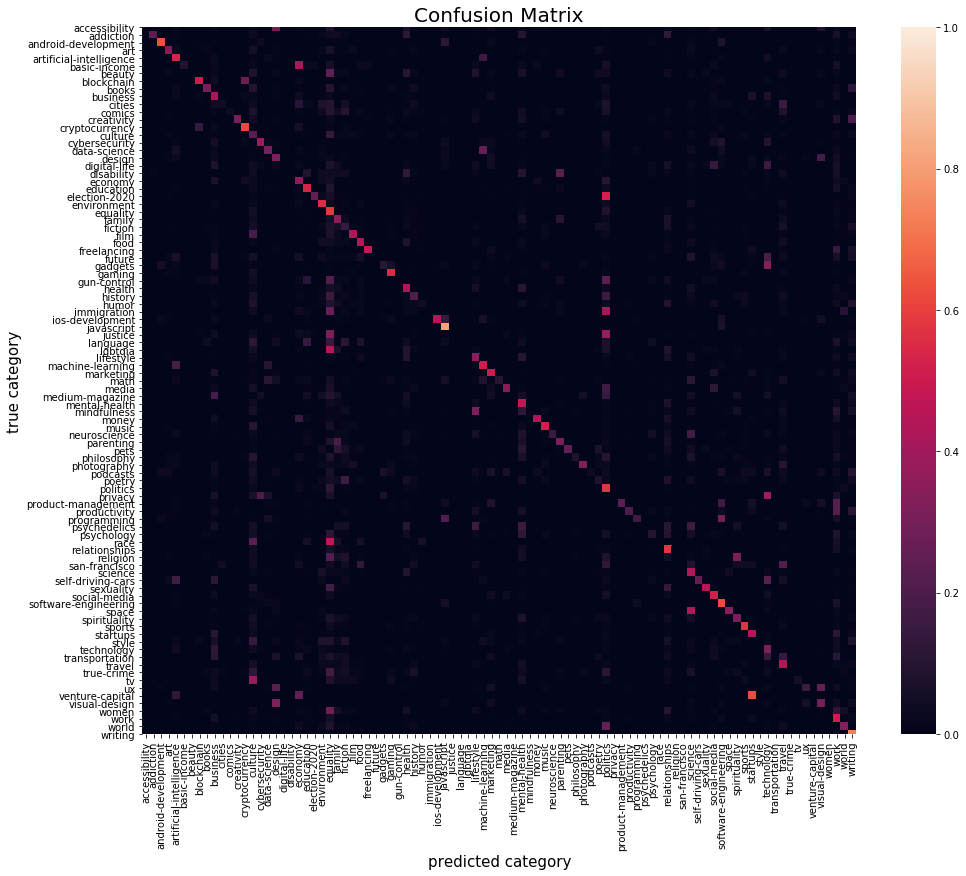

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def reveseOneHot(prediction_output):
    integer_encode = onehot_encoder.inverse_transform(prediction_output).flatten().astype(int)
    return integer_encoder.inverse_transform(integer_encode) 

def plotConfusionMatrix(confusionMatrix, classes):

    confusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
    
    heatmap_df = pd.DataFrame(confusionMatrix, index=classes, columns=classes)
    
    fig, ax = plt.subplots(figsize=(16,13))
    sns.heatmap(heatmap_df, xticklabels=True,yticklabels=True, ax=ax, vmin=0,vmax=1)
    ax.set_aspect("equal")
    plt.title("Confusion Matrix", fontsize=20)
    plt.ylabel("true category", fontsize=15)
    plt.xlabel("predicted category", fontsize=15)

def precisionFromConfusionMatrix(confusionMatrix):
    
    truePos = np.diagonal(confusionMatrix)
    falsePos = np.asarray(confusionMatrix.sum(axis=0)) - truePos
    
    precision = truePos / (truePos + falsePos)
    precision = precision[~np.isnan(precision)]
    
    return precision.mean()

classifier = classifier0
y_pred = reveseOneHot(classifier.predict(XMatrix_test))

category_list = unique_labels(y_test, y_pred)
cMatrix = confusion_matrix(y_test, y_pred, labels=category_list)

plotConfusionMatrix(cMatrix, category_list)

precision = precisionFromConfusionMatrix(cMatrix)
print("Average multiclass precision: {}".format(precision))

Taking a closer look of the confusion matrix generated from the prediction result of the test data, we noticed there were some major pairs of misclassification, partly due to that the involved category are tightly related -- _privacy_ misclassified as *technology*; _basic-income_ misclassified as *economy*; *election-2020*, _immigration_ and _justice_ misclassified as *politics*; _lgbtqia_ and _race_ misclassified as *equality*; _venture-capital_ misclassified as _startup_; _space_ misclassified as *science*...

Compared to the naive Bayes classifier, the average multiclass precision -- 45% -- is about the same level.